E_GS =  [-2.6]
gap =  1.5999999999999996
|<psi0|psiGS>| =  0.0
n= 0


C:\Users\xingj\AppData\Local\Temp\ipykernel_21948\1175014399.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_t=np.int(num_t_1[n])
C:\Users\xingj\AppData\Local\Temp\ipykernel_21948\1175014399.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for

n= 1
n= 2
n= 3
n= 4
n= 5
n= 6
n= 7
n= 8


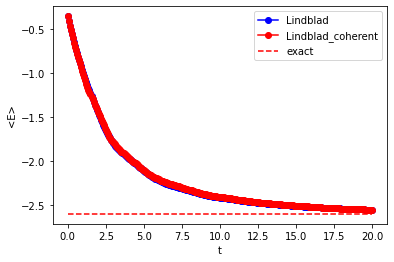

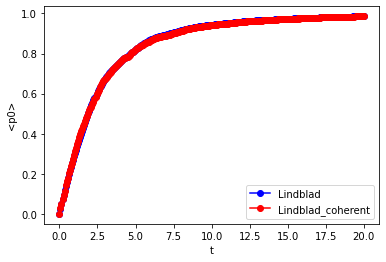

In [1]:
# %load tfim1d.py
"""
Test Lindblad based method for ground state preparation for TFIM.

Lin Lin
Last revision: 04/18/2023
"""

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d

import numpy as np # generic math functions
import scipy.linalg as la
import matplotlib.pyplot as plt
from numpy import linalg as la
from qutip import Qobj, mesolve

from lindblad import Lindblad


if __name__ == "__main__":
    ##### define model parameters #####
    L=2 # system size
    J=1.0 # spin zz interaction
    g=1.2 # z magnetic field strength
    	
    ##### define spin model
    # site-coupling lists (PBC for both spin inversion sectors)
    h_field=[[-g,i] for i in range(L)]
    J_zz=[[-J,i,i+1] for i in range(L-1)] # no PBC
    # define spin static and dynamic lists
    static =[["zz",J_zz],["x",h_field]] # static part of H
    dynamic=[] # time-dependent part of H
    # construct spin basis in pos/neg spin inversion sector depending on APBC/PBC
    spin_basis = spin_basis_1d(L=L)
    # build spin Hamiltonians
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H=hamiltonian(static,dynamic,basis=spin_basis,dtype=np.float64,**no_checks)
    # calculate spin energy levels
    E_GS,psi_GS = H.eigsh(k=1,which="SA")
    psi_GS = psi_GS.flatten()
    print('E_GS = ', E_GS)
    
    H_mat = np.array(H.todense())
    E_H , psi_H = la.eigh(H_mat)
    gap = E_H[1] - E_H[0]
    print('gap = ', gap)

    a = 2*la.norm(H_mat,2)
    da = 2*la.norm(H_mat,2)
    b = 0.3 * gap
    db = 0.3 * gap
    
    filter_params = {'a': a, 'b': b, 'da': da, 'db': db} 

    A = hamiltonian([ ['z',[[1.0,0]]] ],[],basis=spin_basis,dtype=np.float64,**no_checks)
    A_mat = np.array(A.todense())

    lb = Lindblad(H_mat, A_mat, filter_params)

    # fix the random seed
    np.random.seed(seed=1)
    vt = np.random.randn(lb.Ns)
    # worst case in some sense: make psi0 and psi_GS orthogonal
    psi0 = vt.copy()
    psi0 -= psi_GS * np.vdot(psi_GS,psi0)
    psi0 = psi0 / la.norm(psi0)
    print('|<psi0|psiGS>| = ', np.abs(np.vdot(psi_GS,psi0)))
    T = 20
    K = 9
    num_t_1=np.zeros(K)
    rho_error=np.zeros(K)
    for n in range(K):
        print('n=',n)
        num_t_1[n] = T*(1.4**n)
        num_t=np.int(num_t_1[n])
        T_kraus = 5 / db
        Nt_kraus = np.int(T_kraus/(2*np.pi/(4*a)))
        num_segment = 1
        num_rep = 2000
        times = np.arange(num_t+1) * (T/num_t)

        H_obj = Qobj(H_mat)
        zero_obj = Qobj(np.zeros_like(H_mat))

        rho_GS_obj = Qobj(np.outer(psi_GS, psi_GS.conj()))

        mode = 'mesolve'
        lb.construct_kraus_coherent_freq()
        result = mesolve(H_obj, Qobj(psi0), times, [Qobj(lb.A_kraus)])
        mode = 'coherent'
        lb.construct_kraus_coherent_time(T_kraus, Nt_kraus)
        times, avg_H_c, avg_pGS_c, rho_all_c = lb.evolve_kraus_coherent(T, num_t, psi0,
                num_rep, psi_GS)
        for it in range(np.int(num_t)):
            rho_error[n]=rho_error[n]+la.norm(result.states[it]-rho_all_c[:,:,it], 'nuc')
        rho_error[n]=rho_error[n]/np.int(num_t)
        if n==K-1:
            result = mesolve(H_obj, Qobj(psi0), times, [Qobj(lb.A_kraus)],
        [H_obj, rho_GS_obj])
            avg_H = result.expect[0]
            avg_pGS = result.expect[1]
            plt.plot(times, avg_H, 'b-o', label='Lindblad')
            plt.plot(times, avg_H_c, 'r-o', label='Lindblad_coherent')
            plt.plot(times, np.ones_like(times)*E_GS, 'r--', label='exact')
            plt.legend()
            plt.xlabel('t')
            plt.ylabel('<E>')
            plt.show()

            plt.plot(times, avg_pGS, 'b-o', label='Lindblad')
            plt.plot(times, avg_pGS_c, 'r-o', label='Lindblad_coherent')
            plt.legend()
            plt.xlabel('t')
            plt.ylabel('<p0>')
            plt.show()

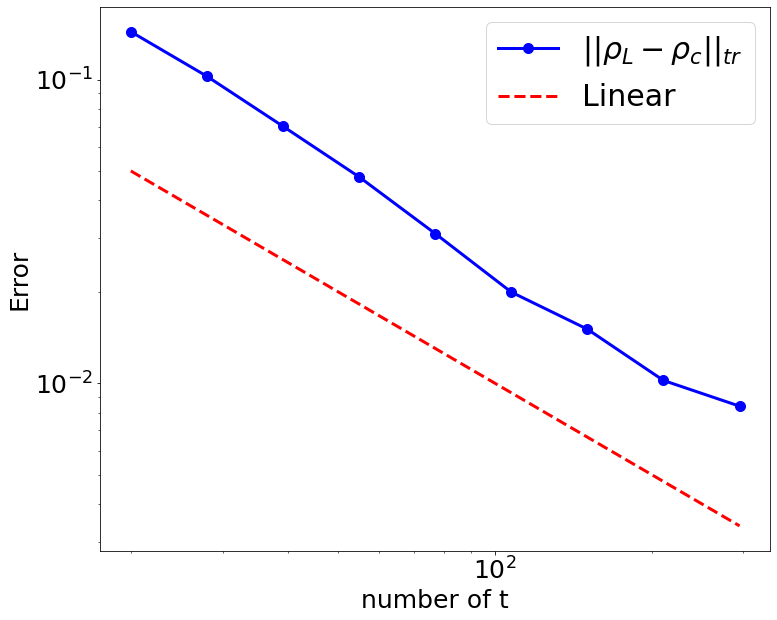

In [2]:
# Error checking (Exact vs coherent)
plt.figure(figsize=(12,10))
plt.plot(num_t_1, np.abs(rho_error), 'b-o', label=r'$||\rho_L-\rho_c||_{tr}$', linewidth=3,markersize=10)
plt.plot(num_t_1, 1/num_t_1, 'r--', label='Linear', linewidth=3,markersize=10)
plt.legend()
plt.xlabel('number of t',fontsize=25)
plt.ylabel('Error',fontsize=25)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.savefig('Error_coherent_vs_continuous.pdf')
plt.show()

C:\Users\xingj\AppData\Local\Temp\ipykernel_21948\1862912314.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x=np.linspace(-10/db,10/db, num=np.int(100/b))


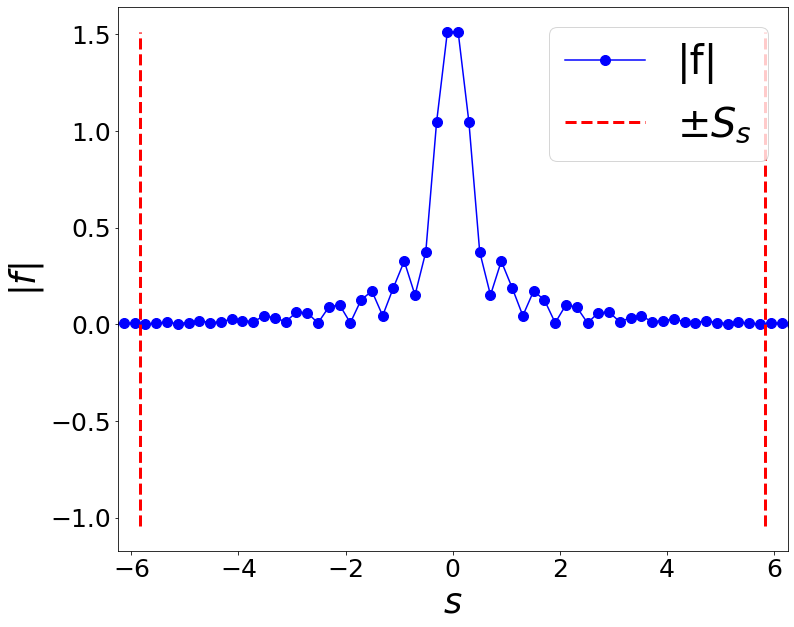

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


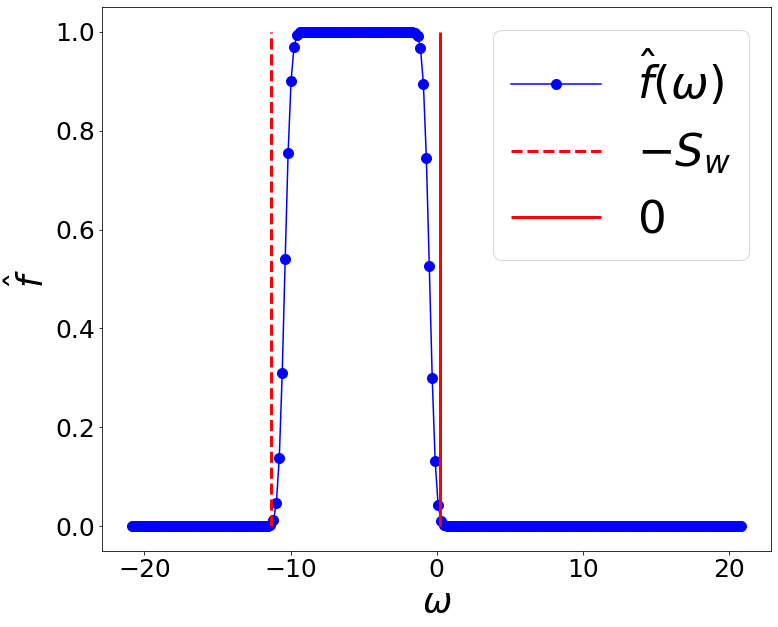

In [13]:
a = 4*la.norm(H_mat,2)
da = 0.3 * gap
b = 0.3 * gap
db = 0.3 * gap
filter_params = {'a': a, 'b': b, 'da': da, 'db': db} 
lb = Lindblad(H_mat, A_mat, filter_params)
x=np.linspace(-10/db,10/db, num=np.int(100/b))
f=np.zeros(len(x),'complex')
hat_f_prefect=np.zeros(len(x),'complex')
for n in range(len(x)):
    f[n]=lb.filter_time(x[n])
    hat_f_prefect[n]=lb.filter_freq(x[n])
plt.figure(figsize=(12,10))
plt.plot(x,np.abs(f), 'o-', color = "b", label='|f|', linewidth=1.5,markersize=10)
# plt.plot(x,np.imag(f), '*-', color = "g", label='Im(f)', linewidth=1.5,markersize=10)
plt.vlines(-2.8/db,min(np.imag(f)), max(np.abs(f)), colors = "r", linestyles = "dashed", 
           label="$\pm S_s$", linewidth=3)
plt.vlines(2.8/db,min(np.imag(f)), max(np.abs(f)), colors = "r", linestyles = "dashed", linewidth=3)
plt.xlabel('$s$',fontsize=35)
plt.ylabel('$|f|$',fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=40,loc='upper right')
plt.xlim(-3/db, 3/db) 
plt.savefig('function_f.pdf')
plt.show()
plt.figure(figsize=(12,10))
plt.plot(x,hat_f_prefect,'o-', color = "b", label=r'$\hat{f}(\omega)$', linewidth=1.5,markersize=10)
plt.vlines(-a-2*da,0, max(hat_f_prefect), colors = "r", linestyles = "dashed", 
           label="$-S_w$", linewidth=3)
plt.vlines(0.2,0, max(hat_f_prefect), colors = "r", 
           label="$0$", linewidth=3)
plt.xlabel('$\omega$',fontsize=35)
plt.ylabel('$\hat{f}$',fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=45,loc='upper right')
plt.savefig('function_hat_f.pdf')
plt.show()